#📌 Projeto de Data Warehouse

Pipeline Completo de Data Warehouse utilizando o Dataset Brazilian E-Commerce Public Dataset by Olist.

Projeto desenvolvido para a conclusão da disciplina de Bancos e Armazéns de Dados do curso de Ciência de Dados da Fatec Jundiaí, ministrada pelo professor Rafael Gross.

Membros do projeto:

- Ariel Ladislau Reises

- João Paulo Martins

- Matheus Castro Alexandre

- Thiago Macedo Vaz

- Sofia Pena



Este notebook conduz, de ponta a ponta, o desenvolvimento completo de um Data Warehouse (DW) utilizando dados reais de comércio eletrônico. O projeto segue a arquitetura clássica de pipelines de dados corporativos e implementa:

1. Staging Layer (Camada de Ingestão)

2. OLTP (Modelo Operacional Normalizado)

3. Data Warehouse (DW)

4. Validação

5. Análises e visualizações

6. Otimização e Performance

# Bibliotecas

In [51]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
import duckdb
import os
from pathlib import Path
import kagglehub

# Importando o dataset Olist direto da API do Kaggle

In [ ]:
# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Path to dataset files: /kaggle/input/brazilian-ecommerce


In [ ]:
for file in os.listdir(path):
    print(file)

olist_customers_dataset.csv
olist_sellers_dataset.csv
olist_order_reviews_dataset.csv
olist_order_items_dataset.csv
olist_products_dataset.csv
olist_geolocation_dataset.csv
product_category_name_translation.csv
olist_orders_dataset.csv
olist_order_payments_dataset.csv


# Etapa de Staging (Criar views das dimensões e fato, sem alterações nos arquivos originais)

Nesta etapa iniciamos a construção do pipeline criando a Camada de Staging, responsável por disponibilizar os dados brutos de forma padronizada para as próximas fases do processo (OLTP → DW).

O objetivo aqui não é transformar os dados, mas apenas organizá-los em views que apontam diretamente para os arquivos CSV originais baixados do Kaggle. Isso garante:

- Reprodutibilidade e rastreabilidade

- Padronização dos esquemas

- Independência entre os dados brutos e as fases posteriores do pipeline

- Facilidade na criação de modelos OLTP e posteriormente na modelagem dimensional

## Criando o arquivo .sql de staging

In [ ]:
%%writefile 00_staging.sql
-- ===============================
-- STAGING: ORDERS
-- ===============================
CREATE OR REPLACE VIEW stg_orders AS
SELECT *
FROM read_csv_auto('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv');


-- ===============================
-- STAGING: ORDER ITEMS
-- ===============================
CREATE OR REPLACE VIEW stg_order_items AS
SELECT *
FROM read_csv_auto('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv');


-- ===============================
-- STAGING: ORDER PAYMENTS
-- ===============================
CREATE OR REPLACE VIEW stg_order_payments AS
SELECT *
FROM read_csv_auto('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv');


-- ===============================
-- STAGING: ORDER REVIEWS
-- ===============================
CREATE OR REPLACE VIEW stg_order_reviews AS
SELECT *
FROM read_csv_auto('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv');


-- ===============================
-- STAGING: PRODUCTS
-- ===============================
CREATE OR REPLACE VIEW stg_products AS
SELECT *
FROM read_csv_auto('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv');


-- ===============================
-- STAGING: CUSTOMERS
-- ===============================
CREATE OR REPLACE VIEW stg_customers AS
SELECT *
FROM read_csv_auto('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv');


-- ===============================
-- STAGING: SELLERS
-- ===============================
CREATE OR REPLACE VIEW stg_sellers AS
SELECT *
FROM read_csv_auto('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv');


-- ===============================
-- STAGING: GEOLOCATION
-- ===============================
CREATE OR REPLACE VIEW stg_geolocation AS
SELECT *
FROM read_csv_auto('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv');


-- ===============================
-- STAGING: CATEGORY TRANSLATION
-- ===============================
CREATE OR REPLACE VIEW stg_category_translation AS
SELECT *
FROM read_csv_auto('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv');

Writing 00_staging.sql


## Iniciando o DuckDB e criando as Views por meio da leitura do arquivo de staging

In [ ]:
# Iniciando o banco de dados no DuckDB
conn = duckdb.connect('/content/olist_dw.duckdb')

# Executa o arquivo de staging
with open('00_staging.sql', 'r') as f:
    sql = f.read()

conn.execute(sql)
print("Views de staging criadas com sucesso!")

Views de staging criadas com sucesso!


### Checando as Views criadas e olhando 5 linhas da Customers

In [ ]:
# listar views (resposta em DataFrame)
views = conn.execute("""
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'main'
  AND table_type = 'VIEW'
ORDER BY table_name;
""").df()
print(views)

# pegar 5 linhas da view stg_customers (se existir)
conn.execute("SELECT * FROM stg_customers LIMIT 5").df()



                 table_name
0  stg_category_translation
1             stg_customers
2           stg_geolocation
3           stg_order_items
4        stg_order_payments
5         stg_order_reviews
6                stg_orders
7              stg_products
8               stg_sellers


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


# Etapa de OLTP

Após organizar os arquivos brutos na camada de Staging, avançamos para a construção do modelo OLTP, que representa uma versão normalizada dos dados, semelhante a bancos transacionais usados em ambientes reais.

Nesta etapa, transformamos as views de staging em tabelas normalizadas, aplicando boas práticas como:

- Separação de entidades

- Criação de chaves primárias

- Garantia de integridade referencial

- Padronização de tipos e nomes de colunas

O objetivo do OLTP é servir como uma base operacional organizada e consistente, reduzindo redundâncias e preparando os dados para a etapa seguinte: a montagem do Data Warehouse (DW).
Essa camada funciona como um middle layer entre os dados brutos e o modelo analítico, fornecendo uma estrutura limpa, normalizada e pronta para ser transformada no modelo dimensional.

## Criando o arquivo .sql de OLTP

In [ ]:
%%writefile 01_oltp.sql
-- ===========================================================
-- Camada OLTP normalizada (a partir do STAGING)
-- ===========================================================

--------------------------------------------------------------
-- DROP TABLES (para idempotência)
--------------------------------------------------------------
DROP TABLE IF EXISTS oltp_customers;
DROP TABLE IF EXISTS oltp_sellers;
DROP TABLE IF EXISTS oltp_products;
DROP TABLE IF EXISTS oltp_orders;
DROP TABLE IF EXISTS oltp_order_items;
DROP TABLE IF EXISTS oltp_order_payments;
DROP TABLE IF EXISTS oltp_order_reviews;
DROP TABLE IF EXISTS oltp_geolocation;
DROP TABLE IF EXISTS oltp_category_translation;


--------------------------------------------------------------
-- CUSTOMERS (CORRIGIDO)
--------------------------------------------------------------
CREATE TABLE oltp_customers AS
SELECT DISTINCT
    customer_id::VARCHAR              AS customer_id,
    customer_unique_id::VARCHAR       AS customer_unique_id,
    customer_zip_code_prefix::VARCHAR AS zip_code_prefix,
    customer_city::VARCHAR            AS customer_city,
    customer_state::VARCHAR           AS customer_state
FROM stg_customers;


--------------------------------------------------------------
-- SELLERS (CORRIGIDO)
--------------------------------------------------------------
CREATE TABLE oltp_sellers AS
SELECT DISTINCT
    seller_id::VARCHAR              AS seller_id,
    seller_zip_code_prefix::VARCHAR AS zip_code_prefix,
    seller_city::VARCHAR            AS seller_city,
    seller_state::VARCHAR           AS seller_state
FROM stg_sellers;


--------------------------------------------------------------
-- PRODUCTS (CORRIGIDO)
--------------------------------------------------------------
CREATE TABLE oltp_products AS
SELECT DISTINCT
    product_id::VARCHAR                  AS product_id,
    product_category_name::VARCHAR       AS product_category_name,
    product_name_lenght::INTEGER         AS product_name_lenght,
    product_description_lenght::INTEGER  AS product_description_lenght,
    product_photos_qty::INTEGER          AS product_photos_qty,
    product_weight_g::DOUBLE             AS product_weight_g,
    product_length_cm::DOUBLE            AS product_length_cm,
    product_height_cm::DOUBLE            AS product_height_cm,
    product_width_cm::DOUBLE             AS product_width_cm
FROM stg_products;


--------------------------------------------------------------
-- ORDERS (CORRIGIDO)
--------------------------------------------------------------
CREATE TABLE oltp_orders AS
SELECT DISTINCT
    order_id::VARCHAR    AS order_id,
    customer_id::VARCHAR AS customer_id,
    order_status::VARCHAR AS order_status,

    CAST(order_purchase_timestamp      AS TIMESTAMP) AS order_purchase_timestamp,
    CAST(order_approved_at             AS TIMESTAMP) AS order_approved_at,
    CAST(order_delivered_carrier_date  AS TIMESTAMP) AS order_delivered_carrier_date,
    CAST(order_delivered_customer_date AS TIMESTAMP) AS order_delivered_customer_date,
    CAST(order_estimated_delivery_date AS TIMESTAMP) AS order_estimated_delivery_date

FROM stg_orders;


--------------------------------------------------------------
-- ORDER ITEMS (CORRIGIDO)
--------------------------------------------------------------
CREATE TABLE oltp_order_items AS
SELECT DISTINCT
    order_id::VARCHAR    AS order_id,
    order_item_id::INTEGER AS order_item_id,
    product_id::VARCHAR  AS product_id,
    seller_id::VARCHAR   AS seller_id,
    CAST(shipping_limit_date AS TIMESTAMP) AS shipping_limit_date,
    price::DOUBLE        AS price,
    freight_value::DOUBLE AS freight_value
FROM stg_order_items;


--------------------------------------------------------------
-- ORDER PAYMENTS (CORRIGIDO)
--------------------------------------------------------------
CREATE TABLE oltp_order_payments AS
SELECT DISTINCT
    order_id::VARCHAR              AS order_id,
    payment_sequential::INTEGER    AS payment_sequential,
    payment_type::VARCHAR          AS payment_type,
    payment_installments::INTEGER  AS payment_installments,
    payment_value::DOUBLE          AS payment_value
FROM stg_order_payments;


--------------------------------------------------------------
-- ORDER REVIEWS (CORRIGIDO)
--------------------------------------------------------------
CREATE TABLE oltp_order_reviews AS
SELECT DISTINCT
    review_id::VARCHAR       AS review_id,
    order_id::VARCHAR        AS order_id,
    review_score::INTEGER    AS review_score,
    review_comment_title::VARCHAR      AS review_comment_title,
    review_comment_message::VARCHAR    AS review_comment_message,
    CAST(review_creation_date     AS TIMESTAMP) AS review_creation_date,
    CAST(review_answer_timestamp  AS TIMESTAMP) AS review_answer_timestamp
FROM stg_order_reviews;


--------------------------------------------------------------
-- GEOLOCATION (CORRIGIDO)
--------------------------------------------------------------
CREATE TABLE oltp_geolocation AS
SELECT DISTINCT
    geolocation_zip_code_prefix::VARCHAR AS zip_code_prefix,
    geolocation_lat::DOUBLE              AS geolocation_lat,
    geolocation_lng::DOUBLE              AS geolocation_lng,
    geolocation_city::VARCHAR            AS geolocation_city,
    geolocation_state::VARCHAR           AS geolocation_state
FROM stg_geolocation;


--------------------------------------------------------------
-- CATEGORY TRANSLATION (CORRIGIDO)
--------------------------------------------------------------
CREATE TABLE oltp_category_translation AS
SELECT DISTINCT
    product_category_name::VARCHAR         AS product_category_name,
    product_category_name_english::VARCHAR AS product_category_name_english
FROM stg_category_translation;

Writing 01_oltp.sql


## Rodando o script de OLTP no DW para criarmos as tabelas

In [ ]:
with open('01_oltp.sql', 'r') as f:
    sql = f.read()

conn.execute(sql)
print("Camada OLTP criada com sucesso!")

Camada OLTP criada com sucesso!


## Checando as tabelas criadas

In [ ]:
conn.execute("""
SELECT table_name
FROM information_schema.tables
WHERE table_type='BASE TABLE' AND table_schema='main'
ORDER BY table_name;
""").df()

,table_name
0,oltp_category_translation
1,oltp_customers
2,oltp_geolocation
3,oltp_order_items
4,oltp_order_payments
5,oltp_order_reviews
6,oltp_orders
7,oltp_products
8,oltp_sellers


In [ ]:
conn.execute("DESCRIBE oltp_order_items").df()

,column_name,column_type,null,key,default,extra
0,order_id,VARCHAR,YES,None,None,None
1,order_item_id,INTEGER,YES,None,None,None
2,product_id,VARCHAR,YES,None,None,None
3,seller_id,VARCHAR,YES,None,None,None
4,shipping_limit_date,TIMESTAMP,YES,None,None,None
5,price,DOUBLE,YES,None,None,None
6,freight_value,DOUBLE,YES,None,None,None


# Etapa do DW e tabelas fato e dimensão

Com o modelo OLTP concluído, avançamos para a construção do Data Warehouse, onde os dados são reorganizados em um formato otimizado para análise. Nesta fase, aplicamos a modelagem dimensional, estruturando as informações em tabelas dimensão e uma tabela fato, conforme o modelo estrela amplamente adotado em projetos de BI.

🔹 Tabelas Dimensão

As dimensões representam os “contextos” que descrevem os fatos — como cliente, vendedor, produto, tempo, localização, categoria e avaliações.
Elas concentram atributos descritivos e textuais, permitindo análises segmentadas e filtragem eficiente.

Principais objetivos das dimensões:

- Fornecer contexto para análises

- Garantir consistência sem redundância

- Facilitar agregações e drill-downs

- Padronizar chaves substitutas (surrogate keys)

🔸 Tabela Fato

A tabela fato consolida os eventos transacionais, agregando métricas quantitativas como:

- Valor pago

- Valor do frete

- Quantidade

- Receita

- Tempos operacionais (aprovação, entrega, etc.)

Cada linha da fato representa uma observação analítica vinculada às dimensões por meio de FKs, garantindo suporte para consultas de alto desempenho.

## Criando o arquivo .sql do DW

In [ ]:
%%writefile 02_dw_model.sql
-- Estrutura do DW (Dimensões + Tabela Fato)
-- Apenas a estrutura — sem inserir dados ainda.
-- ===========================================================

--------------------------------------------------------------
-- Limpeza para idempotência
--------------------------------------------------------------
DROP SEQUENCE IF EXISTS seq_customer;
DROP SEQUENCE IF EXISTS seq_product;
DROP SEQUENCE IF EXISTS seq_seller;
DROP SEQUENCE IF EXISTS seq_payment_type;

DROP TABLE IF EXISTS dim_customer;
DROP TABLE IF EXISTS dim_product;
DROP TABLE IF EXISTS dim_seller;
DROP TABLE IF EXISTS dim_payment_type;
DROP TABLE IF EXISTS dim_date;
DROP TABLE IF EXISTS fact_sales;


--------------------------------------------------------------
-- Criar SEQUENCES (para chaves substitutas: surrogate keys)
--------------------------------------------------------------
CREATE SEQUENCE seq_customer;
CREATE SEQUENCE seq_product;
CREATE SEQUENCE seq_seller;
CREATE SEQUENCE seq_payment_type;


--------------------------------------------------------------
-- DIM_DATE (não tem SCD2, pois data não muda)
--------------------------------------------------------------
CREATE TABLE dim_date (
    date_key        INTEGER PRIMARY KEY,    -- YYYYMMDD
    full_date       DATE NOT NULL,
    year            INTEGER,
    quarter         INTEGER,
    month           INTEGER,
    month_name      VARCHAR,
    week            INTEGER,
    day             INTEGER,
    weekday         VARCHAR
);


--------------------------------------------------------------
-- DIM_CUSTOMER (com SCD2)
--------------------------------------------------------------
CREATE TABLE dim_customer (
    customer_key        INTEGER PRIMARY KEY DEFAULT nextval('seq_customer'),

    -- Natural Keys
    customer_id         VARCHAR,
    customer_unique_id  VARCHAR,

    -- Atributos
    customer_city       VARCHAR,
    customer_state      VARCHAR,
    zip_code_prefix     VARCHAR,

    -- SCD2
    start_date          DATE NOT NULL,
    end_date            DATE,
    is_current          BOOLEAN NOT NULL DEFAULT TRUE
);


--------------------------------------------------------------
-- DIM_PRODUCT (com SCD2)
--------------------------------------------------------------
CREATE TABLE dim_product (
    product_key                 INTEGER PRIMARY KEY DEFAULT nextval('seq_product'),

    -- Natural Key
    product_id                  VARCHAR,

    -- Atributos
    product_category_name       VARCHAR,
    product_category_english    VARCHAR,
    product_weight_g            DOUBLE,
    product_length_cm           DOUBLE,
    product_height_cm           DOUBLE,
    product_width_cm            DOUBLE,

    -- SCD2
    start_date          DATE NOT NULL,
    end_date            DATE,
    is_current          BOOLEAN NOT NULL DEFAULT TRUE
);


--------------------------------------------------------------
-- DIM_SELLER (com SCD2)
--------------------------------------------------------------
CREATE TABLE dim_seller (
    seller_key         INTEGER PRIMARY KEY DEFAULT nextval('seq_seller'),

    -- Natural Key
    seller_id          VARCHAR,

    -- Atributos
    seller_city        VARCHAR,
    seller_state       VARCHAR,
    zip_code_prefix    VARCHAR,

    -- SCD2
    start_date         DATE NOT NULL,
    end_date           DATE,
    is_current         BOOLEAN NOT NULL DEFAULT TRUE
);


--------------------------------------------------------------
-- DIM_PAYMENT_TYPE (pequena e útil)
-- Exemplo: credit_card, boleto, voucher, debit_card
--------------------------------------------------------------
CREATE TABLE dim_payment_type (
    payment_type_key   INTEGER PRIMARY KEY DEFAULT nextval('seq_payment_type'),
    payment_type       VARCHAR UNIQUE
);


--------------------------------------------------------------
-- TABELA FATO: fact_sales
-- Grain: UM item do pedido (order_id + order_item_id)
--------------------------------------------------------------
CREATE TABLE fact_sales (

    -- Surrogate Key opcional (não necessária)
    sales_key              BIGINT PRIMARY KEY,

    -- Foreign Keys
    date_key               INTEGER NOT NULL,  -- Data de compra
    customer_key           INTEGER NOT NULL,
    product_key            INTEGER NOT NULL,
    seller_key             INTEGER NOT NULL,
    payment_type_key       INTEGER,           -- Pode existir mais de 1 por pedido

    -- Medidas de negócio
    price                  DOUBLE,
    freight_value          DOUBLE,
    payment_value          DOUBLE,
    review_score           INTEGER,
    quantity               INTEGER,

    -- Fake Natural Keys (para rastrear origem)
    order_id               VARCHAR,
    order_item_id          INTEGER,

    -- Foreign Key Relations
    FOREIGN KEY (date_key)         REFERENCES dim_date(date_key),
    FOREIGN KEY (customer_key)     REFERENCES dim_customer(customer_key),
    FOREIGN KEY (product_key)      REFERENCES dim_product(product_key),
    FOREIGN KEY (seller_key)       REFERENCES dim_seller(seller_key),
    FOREIGN KEY (payment_type_key) REFERENCES dim_payment_type(payment_type_key)
);

Writing 02_dw_model.sql


## Rodando o arquivo dw_model para criarmos as dimensões e fato

In [ ]:
with open("02_dw_model.sql") as f:
    sql = f.read()

conn.execute(sql)
print("DW criado com sucesso!")

DW criado com sucesso!


## Estrutura do DW
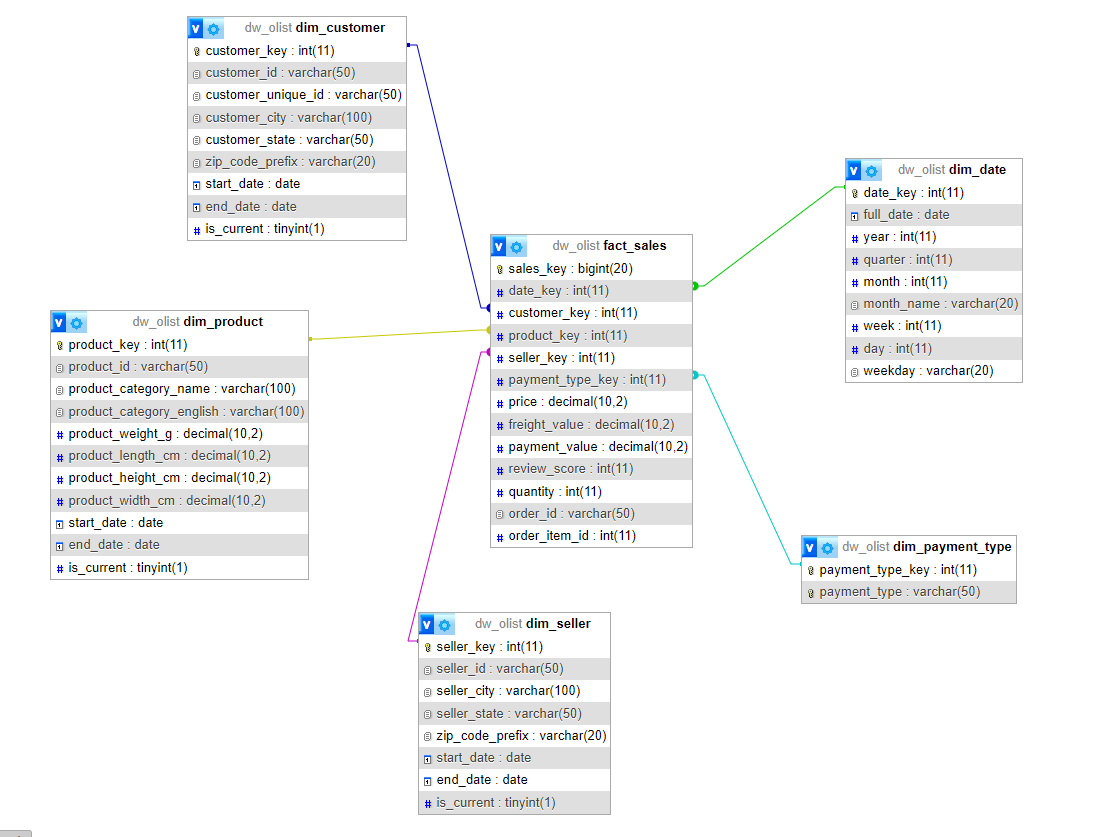

# Etapa de carga

Após a modelagem das tabelas de Staging, OLTP e DW, esta etapa executa o processo de ETL (Extract, Transform, Load) que efetivamente popula todas as estruturas construídas.

## Criando o arquivo .sql de carga de dados

In [ ]:
%%writefile 03_etl_load.sql
-- ETL para carregar dimensões e fato no DW
-- OLTP  --->  DW (SCD2 + fato)
-- ===========================================================

--------------------------------------------------------------
-- 1. DIM_DATE (VERSÃO FINAL PARA DUCKDB — sem to_char)
--------------------------------------------------------------

DELETE FROM fact_sales;

DELETE FROM dim_customer;
DELETE FROM dim_product;
DELETE FROM dim_seller;
DELETE FROM dim_payment_type;
DELETE FROM dim_date;


--------------------------------------------------------------
-- 1. DIM_DATE  (100% compatível com DuckDB)
--------------------------------------------------------------

WITH dates AS (
    SELECT
        MIN(order_purchase_timestamp)::DATE AS start_date,
        MAX(order_purchase_timestamp)::DATE AS end_date
    FROM oltp_orders
),
expanded AS (
    SELECT
        start_date + (i * INTERVAL 1 DAY) AS full_date
    FROM dates,
    range(
        (SELECT date_diff('day', start_date, end_date) + 1 FROM dates)
    ) AS r(i)
)

INSERT INTO dim_date (
    date_key, full_date, year, quarter, month, month_name,
    week, day, weekday
)
SELECT
    CAST(strftime('%Y%m%d', full_date) AS INTEGER),
    full_date,
    EXTRACT(YEAR FROM full_date),
    EXTRACT(QUARTER FROM full_date),
    EXTRACT(MONTH FROM full_date),
    strftime('%B', full_date),
    EXTRACT(WEEK FROM full_date),
    EXTRACT(DAY FROM full_date),
    strftime('%A', full_date)
FROM expanded;


--------------------------------------------------------------
-- 2. DIM_PAYMENT_TYPE
--------------------------------------------------------------

INSERT INTO dim_payment_type (payment_type)
SELECT DISTINCT payment_type
FROM oltp_order_payments
WHERE payment_type IS NOT NULL;


--------------------------------------------------------------
-- 3. DIM_CUSTOMER — SCD2
--------------------------------------------------------------

-- Novos clientes
INSERT INTO dim_customer (
    customer_id, customer_unique_id, customer_city, customer_state,
    zip_code_prefix, start_date, end_date, is_current
)
SELECT
    c.customer_id, c.customer_unique_id, c.customer_city,
    c.customer_state, c.zip_code_prefix,
    CURRENT_DATE, NULL, TRUE
FROM oltp_customers c
LEFT JOIN dim_customer d
    ON c.customer_id = d.customer_id
   AND d.is_current = TRUE
WHERE d.customer_id IS NULL;

-- Clientes alterados
UPDATE dim_customer
SET end_date = CURRENT_DATE - INTERVAL 1 DAY,
    is_current = FALSE
WHERE customer_id IN (
    SELECT c.customer_id
    FROM oltp_customers c
    JOIN dim_customer d
        ON c.customer_id = d.customer_id
    WHERE d.is_current = TRUE
      AND (
            c.customer_city      <> d.customer_city OR
            c.customer_state     <> d.customer_state OR
            c.zip_code_prefix    <> d.zip_code_prefix
      )
);

-- Inserção das versões novas
INSERT INTO dim_customer (
    customer_id, customer_unique_id, customer_city, customer_state,
    zip_code_prefix, start_date, end_date, is_current
)
SELECT
    c.customer_id, c.customer_unique_id, c.customer_city,
    c.customer_state, c.zip_code_prefix,
    CURRENT_DATE, NULL, TRUE
FROM oltp_customers c
JOIN dim_customer d
     ON c.customer_id = d.customer_id
WHERE d.end_date = CURRENT_DATE - INTERVAL 1 DAY;



--------------------------------------------------------------
-- 4. DIM_PRODUCT — SCD2
--------------------------------------------------------------

-- Novos produtos
INSERT INTO dim_product (
    product_id, product_category_name, product_category_english,
    product_weight_g, product_length_cm, product_height_cm,
    product_width_cm, start_date, end_date, is_current
)
SELECT
    p.product_id, p.product_category_name,
    t.product_category_name_english,
    p.product_weight_g, p.product_length_cm, p.product_height_cm,
    p.product_width_cm,
    CURRENT_DATE, NULL, TRUE
FROM oltp_products p
LEFT JOIN dim_product d
       ON p.product_id = d.product_id
      AND d.is_current = TRUE
LEFT JOIN oltp_category_translation t
       ON p.product_category_name = t.product_category_name
WHERE d.product_id IS NULL;

-- Produtos alterados
UPDATE dim_product
SET end_date = CURRENT_DATE - INTERVAL 1 DAY,
    is_current = FALSE
WHERE product_id IN (
    SELECT p.product_id
    FROM oltp_products p
    JOIN dim_product d
       ON p.product_id = d.product_id
    WHERE d.is_current = TRUE
      AND (
          p.product_category_name <> d.product_category_name OR
          p.product_weight_g      <> d.product_weight_g OR
          p.product_length_cm     <> d.product_length_cm OR
          p.product_height_cm     <> d.product_height_cm OR
          p.product_width_cm      <> d.product_width_cm
      )
);

-- Inserção das versões novas
INSERT INTO dim_product (
    product_id, product_category_name, product_category_english,
    product_weight_g, product_length_cm, product_height_cm,
    product_width_cm, start_date, end_date, is_current
)
SELECT
    p.product_id, p.product_category_name,
    t.product_category_name_english,
    p.product_weight_g, p.product_length_cm, p.product_height_cm,
    p.product_width_cm,
    CURRENT_DATE, NULL, TRUE
FROM oltp_products p
JOIN dim_product d
     ON p.product_id = d.product_id
LEFT JOIN oltp_category_translation t
       ON p.product_category_name = t.product_category_name
WHERE d.end_date = CURRENT_DATE - INTERVAL 1 DAY;



--------------------------------------------------------------
-- 5. DIM_SELLER — SCD2
--------------------------------------------------------------

-- Novos
INSERT INTO dim_seller (
    seller_id, seller_city, seller_state, zip_code_prefix,
    start_date, end_date, is_current
)
SELECT
    s.seller_id, s.seller_city, s.seller_state, s.zip_code_prefix,
    CURRENT_DATE, NULL, TRUE
FROM oltp_sellers s
LEFT JOIN dim_seller d
       ON s.seller_id = d.seller_id
      AND d.is_current = TRUE
WHERE d.seller_id IS NULL;

-- Alterados
UPDATE dim_seller
SET end_date = CURRENT_DATE - INTERVAL 1 DAY,
    is_current = FALSE
WHERE seller_id IN (
    SELECT s.seller_id
    FROM oltp_sellers s
    JOIN dim_seller d
       ON s.seller_id = d.seller_id
    WHERE d.is_current = TRUE
      AND (
            s.seller_city      <> d.seller_city OR
            s.seller_state     <> d.seller_state OR
            s.zip_code_prefix  <> d.zip_code_prefix
          )
);

-- Versões novas
INSERT INTO dim_seller (
    seller_id, seller_city, seller_state, zip_code_prefix,
    start_date, end_date, is_current
)
SELECT
    s.seller_id, s.seller_city, s.seller_state, s.zip_code_prefix,
    CURRENT_DATE, NULL, TRUE
FROM oltp_sellers s
JOIN dim_seller d
     ON s.seller_id = d.seller_id
WHERE d.end_date = CURRENT_DATE - INTERVAL 1 DAY;



--------------------------------------------------------------
-- 6. FACT_SALES — VERSÃO FINAL (SEM DUPLICAÇÃO DE REVIEWS)
--------------------------------------------------------------

-- REVIEW ÚNICA POR PEDIDO
WITH latest_reviews AS (
    SELECT *
    FROM (
        SELECT
            review_id,
            order_id,
            review_score,
            review_comment_title,
            review_comment_message,
            review_creation_date,
            review_answer_timestamp,
            ROW_NUMBER() OVER (
                PARTITION BY order_id
                ORDER BY review_creation_date DESC
            ) AS rn
        FROM oltp_order_reviews
    )
    WHERE rn = 1
)

INSERT INTO fact_sales (
    sales_key, date_key, customer_key, product_key, seller_key,
    payment_type_key, price, freight_value, payment_value,
    review_score, quantity, order_id, order_item_id
)
SELECT
    ROW_NUMBER() OVER () AS sales_key,

    CAST(strftime('%Y%m%d', o.order_purchase_timestamp)::INT AS INTEGER),

    dc.customer_key,
    dp.product_key,
    ds.seller_key,
    dpt.payment_type_key,

    oi.price,
    oi.freight_value,
    op.payment_value,
    rv.review_score,

    1 AS quantity,

    oi.order_id,
    oi.order_item_id

FROM oltp_order_items oi
JOIN oltp_orders o
    ON oi.order_id = o.order_id
JOIN oltp_customers c
    ON o.customer_id = c.customer_id
JOIN dim_customer dc
    ON c.customer_id = dc.customer_id AND dc.is_current = TRUE
JOIN oltp_products p
    ON oi.product_id = p.product_id
JOIN dim_product dp
    ON p.product_id = dp.product_id AND dp.is_current = TRUE
JOIN oltp_sellers s
    ON oi.seller_id = s.seller_id
JOIN dim_seller ds
    ON s.seller_id = ds.seller_id AND ds.is_current = TRUE

LEFT JOIN oltp_order_payments op
    ON oi.order_id = op.order_id
   AND op.payment_sequential = 1

LEFT JOIN dim_payment_type dpt
    ON op.payment_type = dpt.payment_type

LEFT JOIN latest_reviews rv
    ON oi.order_id = rv.order_id;

Writing 03_etl_load.sql


In [ ]:
with open("03_etl_load.sql") as f:
    sql = f.read()

conn.execute(sql)
print("ETL carregado com sucesso!")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

ETL carregado com sucesso!


# Etapa de validação

O objetivo desta fase é garantir que:

- As tabelas fato e dimensão foram populadas corretamente;

- Não existam violações de integridade referencial;

- O volume de registros esteja coerente com o OLTP;

- As chaves estrangeiras estejam completas;

- A dimensão de datas cubra todo o período do dataset;

- Não existam problemas nos controles de histórico tipo SCD2.

Para isso, implementamos uma rotina de validação automatizada que verifica diversos pontos críticos:

🔹 1) Contagem de Registros

Compara o volume do OLTP com o DW para identificar inconsistências.
Regra principal: a tabela fato nunca pode ter mais registros do que o número total de itens no transacional.

🔹 2) Presença de FKs

Valida se as chaves estrangeiras essenciais (cliente, produto, vendedor, data) não estão nulas na fato.

🔹 3) Integridade Dimensional

Garante que cada linha da fato encontra correspondência em suas respectivas dimensões — um dos requisitos fundamentais de um DW confiável.

🔹 4) Intervalo de Datas

Compara o range gerado na dim_date com o range real dos pedidos no OLTP, garantindo cobertura total do período analisado.

🔹 5) Validação SCD2

Verifica se as dimensões com controle de histórico não apresentam múltiplos registros marcados como is_current para o mesmo ID — algo que invalidaria a linha do tempo do cliente, produto ou vendedor.

In [ ]:
# Conexão com o DW
conn = conn


def passfail(title, condition):
    """Imprime PASS/FAIL de forma limpa."""
    if condition:
        print(f"✔ PASS — {title}")
    else:
        print(f"✘ FAIL — {title}")


print("\n===============================")
print("VALIDAÇÃO ROBUSTA DO DW - OLIST")
print("===============================\n")


# ============================================================
# 1) CONTAGENS (com tolerância)
# ============================================================
print("1) CONTAGENS\n")

orders = conn.execute("SELECT COUNT(*) FROM oltp_orders").fetchone()[0]
items  = conn.execute("SELECT COUNT(*) FROM oltp_order_items").fetchone()[0]
facts  = conn.execute("SELECT COUNT(*) FROM fact_sales").fetchone()[0]

print(f"OLTP Orders       : {orders}")
print(f"OLTP Order Items  : {items}")
print(f"DW Fact Rows      : {facts}")

# A regra segura é: a fato não pode ter MAIS itens do que o OLTP.
passfail(
    "fact_sales não excede order_items",
    facts <= items
)


# ============================================================
# 2) FKs NULAS (exceto payment)
# ============================================================
print("\n2) CHAVES ESTRANGEIRAS NULAS\n")

# Listas esperadas
checks = {
    "customer_key": "customer_key IS NULL",
    "product_key":  "product_key IS NULL",
    "seller_key":   "seller_key IS NULL",
    "date_key":     "date_key IS NULL",
}

for label, condition in checks.items():
    q = f"SELECT COUNT(*) FROM fact_sales WHERE {condition}"
    count = conn.execute(q).fetchone()[0]
    passfail(f"{label} não nulo", count == 0)

# payment_key pode ser NULL em pedidos sem pagamento
pay_null = conn.execute("""
SELECT COUNT(*)
FROM fact_sales
WHERE payment_type_key IS NULL
""").fetchone()[0]

print(f"payment_type_key NULL encontrados: {pay_null}")
passfail(
    "payment_type_key pode ser NULL (somente informativo)",
    True
)


# ============================================================
# 3) INTEGRIDADE DIMENSIONAL REAL
# ============================================================
print("\n3) INTEGRIDADE DIMENSIONAL\n")

tests = {
    "Cliente faltando na dimensão":
        """
        SELECT COUNT(*)
        FROM fact_sales fs
        LEFT JOIN dim_customer dc USING (customer_key)
        WHERE dc.customer_key IS NULL
        """,

    "Produto faltando na dimensão":
        """
        SELECT COUNT(*)
        FROM fact_sales fs
        LEFT JOIN dim_product dp USING (product_key)
        WHERE dp.product_key IS NULL
        """,

    "Seller faltando na dimensão":
        """
        SELECT COUNT(*)
        FROM fact_sales fs
        LEFT JOIN dim_seller ds USING (seller_key)
        WHERE ds.seller_key IS NULL
        """,
}

for title, sql in tests.items():
    count = conn.execute(sql).fetchone()[0]
    passfail(title, count == 0)


# ============================================================
# 4) RANGE DE DATAS
# ============================================================
print("\n4) RANGE DE DATA\n")

dw_dates = conn.execute("""
SELECT
    MIN(full_date)::DATE,
    MAX(full_date)::DATE
FROM dim_date
""").fetchone()

raw_dates = conn.execute("""
SELECT
    MIN(order_purchase_timestamp)::DATE,
    MAX(order_purchase_timestamp)::DATE
FROM oltp_orders
""").fetchone()

print("DW Date Range :", dw_dates)
print("Raw Date Range:", raw_dates)

passfail(
    "dim_date cobre todo o intervalo de datas",
    dw_dates == raw_dates
)


# ============================================================
# 5) SCD2 VALIDAÇÃO
# ============================================================
print("\n5) SCD2\n")

tests_scd = {
    "dim_customer sem múltiplos is_current":
        """
        SELECT COUNT(*)
        FROM (
            SELECT customer_id, SUM(is_current::INT) AS curr
            FROM dim_customer
            GROUP BY customer_id
            HAVING curr > 1
        )
        """,

    "dim_product sem múltiplos is_current":
        """
        SELECT COUNT(*)
        FROM (
            SELECT product_id, SUM(is_current::INT) AS curr
            FROM dim_product
            GROUP BY product_id
            HAVING curr > 1
        )
        """,

    "dim_seller sem múltiplos is_current":
        """
        SELECT COUNT(*)
        FROM (
            SELECT seller_id, SUM(is_current::INT) AS curr
            FROM dim_seller
            GROUP BY seller_id
            HAVING curr > 1
        )
        """,
}

for title, sql in tests_scd.items():
    count = conn.execute(sql).fetchone()[0]
    passfail(title, count == 0)


print("\n===============================")
print("VALIDAÇÃO FINALIZADA")
print("===============================\n")


VALIDAÇÃO ROBUSTA DO DW - OLIST

1) CONTAGENS

OLTP Orders       : 99441
OLTP Order Items  : 112650
DW Fact Rows      : 112650
✔ PASS — fact_sales não excede order_items

2) CHAVES ESTRANGEIRAS NULAS

✔ PASS — customer_key não nulo
✔ PASS — product_key não nulo
✔ PASS — seller_key não nulo
✔ PASS — date_key não nulo
payment_type_key NULL encontrados: 92
✔ PASS — payment_type_key pode ser NULL (somente informativo)

3) INTEGRIDADE DIMENSIONAL

✔ PASS — Cliente faltando na dimensão
✔ PASS — Produto faltando na dimensão
✔ PASS — Seller faltando na dimensão

4) RANGE DE DATA

DW Date Range : (datetime.date(2016, 9, 4), datetime.date(2018, 10, 17))
Raw Date Range: (datetime.date(2016, 9, 4), datetime.date(2018, 10, 17))
✔ PASS — dim_date cobre todo o intervalo de datas

5) SCD2

✔ PASS — dim_customer sem múltiplos is_current
✔ PASS — dim_product sem múltiplos is_current
✔ PASS — dim_seller sem múltiplos is_current

VALIDAÇÃO FINALIZADA



## Criar o arquivo analytics.sql com o código acima apenas em sql

In [ ]:
%%writefile 04_analytics.sql
-- ANALYTICS.SQL — Validação do Data Warehouse Olist
-- Todas as validações retornam um número:
--   0  = PASS
--  >0  = FAIL
------------------------------------------------------------


------------------------------------------------------------
-- 1) CONTAGENS
------------------------------------------------------------

-- Quantidade de pedidos na bronze (OLTP)
SELECT COUNT(*) AS oltp_orders FROM oltp_orders;

-- Quantidade de itens de pedido
SELECT COUNT(*) AS oltp_order_items FROM oltp_order_items;

-- Quantidade de linhas na fato
SELECT COUNT(*) AS dw_fact_sales FROM fact_sales;

-- FAIL se o número da fato exceder o número de order_items
SELECT
    CASE WHEN
        (SELECT COUNT(*) FROM fact_sales)
        <=
        (SELECT COUNT(*) FROM oltp_order_items)
    THEN 0 ELSE 1 END AS fail_fact_exceeds_items;


------------------------------------------------------------
-- 2) FKs NULAS (exceto payment_type_key)
------------------------------------------------------------

-- Customer
SELECT COUNT(*) AS fk_customer_null
FROM fact_sales
WHERE customer_key IS NULL;

-- Product
SELECT COUNT(*) AS fk_product_null
FROM fact_sales
WHERE product_key IS NULL;

-- Seller
SELECT COUNT(*) AS fk_seller_null
FROM fact_sales
WHERE seller_key IS NULL;

-- Date
SELECT COUNT(*) AS fk_date_null
FROM fact_sales
WHERE date_key IS NULL;

-- Payment pode ser NULL, apenas informativo
SELECT COUNT(*) AS fk_payment_null
FROM fact_sales
WHERE payment_type_key IS NULL;


------------------------------------------------------------
-- 3) INTEGRIDADE DIMENSIONAL (tabelas de dimensão completas)
------------------------------------------------------------

-- Clientes faltando
SELECT COUNT(*) AS missing_customers
FROM fact_sales fs
LEFT JOIN dim_customer dc USING (customer_key)
WHERE dc.customer_key IS NULL;

-- Produtos faltando
SELECT COUNT(*) AS missing_products
FROM fact_sales fs
LEFT JOIN dim_product dp USING (product_key)
WHERE dp.product_key IS NULL;

-- Sellers faltando
SELECT COUNT(*) AS missing_sellers
FROM fact_sales fs
LEFT JOIN dim_seller ds USING (seller_key)
WHERE ds.seller_key IS NULL;


------------------------------------------------------------
-- 4) RANGE DE DATAS (dim_date cobre o período)
------------------------------------------------------------

-- Datas na dimensão
SELECT
    MIN(full_date) AS dw_min_date,
    MAX(full_date) AS dw_max_date
FROM dim_date;

-- Datas reais nos pedidos
SELECT
    MIN(order_purchase_timestamp)::DATE AS raw_min_date,
    MAX(order_purchase_timestamp)::DATE AS raw_max_date
FROM oltp_orders;

-- FAIL se ranges forem diferentes
SELECT
    CASE WHEN
        (SELECT MIN(full_date) FROM dim_date) =
        (SELECT MIN(order_purchase_timestamp)::DATE FROM oltp_orders)
    AND
        (SELECT MAX(full_date) FROM dim_date) =
        (SELECT MAX(order_purchase_timestamp)::DATE FROM oltp_orders)
    THEN 0 ELSE 1 END AS fail_date_range;


------------------------------------------------------------
-- 5) SCD2 (somente um is_current por ID)
------------------------------------------------------------

-- Customer
SELECT COUNT(*) AS scd_customer_fail
FROM (
    SELECT customer_id, SUM(is_current::INT) AS curr
    FROM dim_customer
    GROUP BY customer_id
    HAVING curr > 1
);

-- Product
SELECT COUNT(*) AS scd_product_fail
FROM (
    SELECT product_id, SUM(is_current::INT) AS curr
    FROM dim_product
    GROUP BY product_id
    HAVING curr > 1
);

-- Seller
SELECT COUNT(*) AS scd_seller_fail
FROM (
    SELECT seller_id, SUM(is_current::INT) AS curr
    FROM dim_seller
    GROUP BY seller_id
    HAVING curr > 1
);

Writing 04_analytics.sql


# Consultas Analíticas

Com o Data Warehouse devidamente estruturado e validado, avançamos para a etapa de Consultas Analíticas, onde exploramos o poder do modelo dimensional para extrair insights de negócio.
Nesta fase, utilizamos principalmente a tabela fato (fact_sales) combinada com suas respectivas dimensões para responder perguntas típicas de análise de vendas, comportamento do cliente e desempenho operacional.

1 - Evolução mensal das vendas no tempo


 Mostra como o total vendido muda mês a mês.

In [ ]:
# ====================================================
# 1) Evolução mensal das vendas
# ====================================================
def vendas_por_mes(conn):
    print("\n📈 ANÁLISE TEMPORAL — VENDAS POR MÊS\n")

    query = """
    SELECT
        d.year,
        d.month,
        SUM(f.price) AS total_vendas,
        SUM(f.freight_value) AS total_frete,
        COUNT(*) AS quantidade_itens
    FROM fact_sales f
    JOIN dim_date d
        ON f.date_key = d.date_key
    GROUP BY d.year, d.month
    ORDER BY d.year, d.month;
    """

    df = conn.execute(query).df()
    display(df)


# ====================================================
# 2) Top 10 produtos mais vendidos
# ====================================================
def top10_produtos(conn):
    print("\n🏆 RANKING — TOP 10 PRODUTOS MAIS VENDIDOS\n")

    query = """
    SELECT
        p.product_id,
        p.product_category_english AS categoria,
        COUNT(*) AS itens_vendidos,
        SUM(f.price) AS receita_total
    FROM fact_sales f
    JOIN dim_product p
        ON f.product_key = p.product_key
    GROUP BY p.product_id, p.product_category_english
    ORDER BY itens_vendidos DESC
    LIMIT 10;
    """

    df = conn.execute(query).df()
    display(df)


# ====================================================
# 3) Vendas por categoria e estado
# ====================================================
def vendas_categoria_estado(conn):
    print("\n🌎 AGREGAÇÃO MULTIDIMENSIONAL — CATEGORIA × ESTADO\n")

    query = """
    SELECT
        p.product_category_english AS categoria,
        c.customer_state AS estado,
        COUNT(*) AS qtd_vendas,
        SUM(f.price) AS receita,
        AVG(f.price) AS ticket_medio
    FROM fact_sales f
    JOIN dim_product p ON f.product_key = p.product_key
    JOIN dim_customer c ON f.customer_key = c.customer_key
    GROUP BY categoria, estado
    ORDER BY receita DESC;
    """

    df = conn.execute(query).df()
    display(df)


# ====================================================
# 4) Cohort de retenção de clientes
# ====================================================
def cohort_clientes(conn):
    print("\n🔄 COHORT — RETENÇÃO DE CLIENTES\n")

    query = """
    WITH first_purchase AS (
        SELECT
            f.customer_key,
            MIN(d.year * 100 + d.month) AS cohort_month
        FROM fact_sales f
        JOIN dim_date d ON f.date_key = d.date_key
        GROUP BY f.customer_key
    ),
    purchases AS (
        SELECT
            f.customer_key,
            d.year * 100 + d.month AS purchase_month
        FROM fact_sales f
        JOIN dim_date d ON f.date_key = d.date_key
    )
    SELECT
        fp.cohort_month,
        COUNT(DISTINCT p.customer_key) AS clientes_ativos_no_mes
    FROM first_purchase fp
    JOIN purchases p
        ON fp.customer_key = p.customer_key
    GROUP BY fp.cohort_month
    ORDER BY fp.cohort_month;
    """

    df = conn.execute(query).df()
    display(df)


# ====================================================
# 5) Ticket médio por estado
# ====================================================
def ticket_medio_estado(conn):
    print("\n💰 KPI — TICKET MÉDIO POR ESTADO\n")

    query = """
    SELECT
        c.customer_state AS estado,
        AVG(f.price) AS ticket_medio,
        SUM(f.price) AS receita_total,
        COUNT(*) AS total_itens
    FROM fact_sales f
    JOIN dim_customer c ON f.customer_key = c.customer_key
    GROUP BY estado
    ORDER BY ticket_medio DESC;
    """

    df = conn.execute(query).df()
    display(df)

As análises realizadas incluem:

🔹 Análises Temporais

Avaliação da evolução das vendas ao longo do tempo, permitindo identificar sazonalidade, picos de demanda, períodos de maior faturamento e variações mensais no volume de pedidos.

🔹 Rankings e Desempenho de Produtos

Identificação dos produtos e categorias com maior volume de vendas, maior receita e maior relevância dentro do portfólio — fundamentais para decisões de estoque, marketing e logística.

🔹 Análises Multidimensionais

Combinações entre diferentes dimensões (ex.: categoria × estado, produto × cliente, etc.) para revelar padrões geográficos, preferências regionais e distribuições de consumo.

🔹 Cohorts e Retenção de Clientes

Estudo do comportamento longitudinal dos clientes para identificar fidelização, recorrência de compras e desempenho por grupo de aquisição.

🔹 KPIs de Negócio

Cálculo de métricas importantes como ticket médio, receita por estado, quantidade de itens, entre outras, que auxiliam na construção de dashboards e no acompanhamento estratégico.

In [ ]:
vendas_por_mes(conn)
top10_produtos(conn)
vendas_categoria_estado(conn)
cohort_clientes(conn)
ticket_medio_estado(conn)


📈 ANÁLISE TEMPORAL — VENDAS POR MÊS



,year,month,total_vendas,total_frete,quantidade_itens
0,2016,9,267.36,87.39,6
1,2016,10,49507.66,7301.18,363
2,2016,12,10.90,8.72,1
3,2017,1,120312.87,16875.62,955
4,2017,2,247303.02,38977.60,1951
5,2017,3,374344.30,57704.29,3000
6,2017,4,359927.23,52495.01,2684
7,2017,5,506071.14,80119.81,4136
8,2017,6,433038.60,69924.44,3583
9,2017,7,498031.48,86940.14,4519



🏆 RANKING — TOP 10 PRODUTOS MAIS VENDIDOS



,product_id,categoria,itens_vendidos,receita_total
0,aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,527,37608.90
1,99a4788cb24856965c36a24e339b6058,bed_bath_table,488,43025.56
2,422879e10f46682990de24d770e7f83d,garden_tools,484,26577.22
3,389d119b48cf3043d311335e499d9c6b,garden_tools,392,21440.59
4,368c6c730842d78016ad823897a372db,garden_tools,388,21056.80
5,53759a2ecddad2bb87a079a1f1519f73,garden_tools,373,20387.20
6,d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories,343,47214.51
7,53b36df67ebb7c41585e8d54d6772e08,watches_gifts,323,37683.42
8,154e7e31ebfa092203795c972e5804a6,health_beauty,281,6325.19
9,3dd2a17168ec895c781a9191c1e95ad7,computers_accessories,274,41082.60



🌎 AGREGAÇÃO MULTIDIMENSIONAL — CATEGORIA × ESTADO



,categoria,estado,qtd_vendas,receita,ticket_medio
0,bed_bath_table,SP,5235,478284.52,91.362850
1,health_beauty,SP,4204,462305.22,109.967940
2,watches_gifts,SP,2281,435009.92,190.710180
3,sports_leisure,SP,3667,386357.01,105.360515
4,computers_accessories,SP,3170,350747.88,110.646019
...,...,...,...,...,...
1377,drinks,AL,1,15.49,15.490000
1378,home_comfort_2,ES,1,12.90,12.900000
1379,home_comfort_2,BA,1,12.90,12.900000
1380,home_comfort_2,PR,1,12.90,12.900000



🔄 COHORT — RETENÇÃO DE CLIENTES



,cohort_month,clientes_ativos_no_mes
0,201609,3
1,201610,308
2,201612,1
3,201701,789
4,201702,1733
5,201703,2641
6,201704,2391
7,201705,3660
8,201706,3217
9,201707,3969



💰 KPI — TICKET MÉDIO POR ESTADO



,estado,ticket_medio,receita_total,total_itens
0,PB,191.475216,1.152681e+05,602
1,AL,180.889212,8.031481e+04,444
2,AC,173.727717,1.598295e+04,92
3,RO,165.973525,4.614064e+04,278
4,PA,165.692417,1.789478e+05,1080
5,AP,164.320732,1.347430e+04,82
6,PI,160.358081,8.691408e+04,542
7,TO,157.529333,4.962174e+04,315
8,RN,156.965936,8.303498e+04,529
9,CE,153.758261,2.272547e+05,1478


## Outras métricas úteis

In [ ]:
def tempo_entrega_por_estado(conn):
    print("\n🚚 TEMPO MÉDIO DE ENTREGA POR ESTADO\n")

    query = """
    SELECT
        c.customer_state AS estado,
        AVG(
            DATE_DIFF(
                'day',
                o.order_purchase_timestamp::DATE,
                o.order_delivered_customer_date::DATE
            )
        ) AS dias_medio_entrega,
        COUNT(*) AS total_pedidos
    FROM fact_sales f
    JOIN oltp_orders o ON f.order_id = o.order_id
    JOIN dim_customer c ON f.customer_key = c.customer_key
    WHERE o.order_delivered_customer_date IS NOT NULL
    GROUP BY estado
    ORDER BY dias_medio_entrega DESC;
    """

    df = conn.execute(query).df()
    display(df)

def entregas_atrasadas(conn):
    print("\n⏰ PORCENTAGEM DE ENTREGAS ATRASADAS POR ESTADO\n")

    query = """
    SELECT
        c.customer_state AS estado,
        SUM(CASE
                WHEN o.order_delivered_customer_date > o.order_estimated_delivery_date
                THEN 1 ELSE 0 END
        ) AS entregas_atrasadas,
        COUNT(*) AS total_pedidos,
        ROUND(100.0 *
            SUM(CASE
                    WHEN o.order_delivered_customer_date > o.order_estimated_delivery_date
                    THEN 1 ELSE 0 END
            ) / COUNT(*), 2) AS percentual_atraso
    FROM fact_sales f
    JOIN oltp_orders o ON f.order_id = o.order_id
    JOIN dim_customer c ON f.customer_key = c.customer_key
    WHERE o.order_delivered_customer_date IS NOT NULL
    GROUP BY estado
    ORDER BY percentual_atraso DESC;
    """

    df = conn.execute(query).df()
    display(df)

def reviews_por_categoria(conn):
    print("\n⭐ AVALIAÇÕES MÉDIAS POR CATEGORIA\n")

    query = """
    SELECT
        p.product_category_english AS categoria,
        AVG(f.review_score) AS media_score,
        COUNT(*) AS total_reviews
    FROM fact_sales f
    JOIN dim_product p ON f.product_key = p.product_key
    WHERE f.review_score IS NOT NULL
    GROUP BY categoria
    HAVING COUNT(*) >= 30  -- evita categorias com poucos dados
    ORDER BY media_score ASC;
    """

    df = conn.execute(query).df()
    display(df)

def vendas_por_dia_da_semana(conn):
    print("\n📅 VENDAS POR DIA DA SEMANA\n")

    query = """
    SELECT
        d.weekday AS dia_semana,
        COUNT(*) AS total_vendas,
        SUM(f.price) AS receita
    FROM fact_sales f
    JOIN dim_date d ON f.date_key = d.date_key
    GROUP BY d.weekday
    ORDER BY total_vendas DESC;
    """

    df = conn.execute(query).df()
    display(df)

def curva_abc_produtos(conn):
    print("\n📊 CURVA ABC — PRODUTOS QUE GERAM 80% DA RECEITA\n")

    query = """
    WITH receita_produtos AS (
        SELECT
            p.product_id,
            p.product_category_english AS categoria,
            SUM(f.price) AS receita
        FROM fact_sales f
        JOIN dim_product p ON f.product_key = p.product_key
        GROUP BY p.product_id, p.product_category_english
    ),
    acumulado AS (
        SELECT
            *,
            receita / SUM(receita) OVER () AS perc_total,
            SUM(receita) OVER (ORDER BY receita DESC)
                / SUM(receita) OVER () AS perc_acumulado
        FROM receita_produtos
    )
    SELECT *
    FROM acumulado
    WHERE perc_acumulado <= 0.80
    ORDER BY receita DESC;
    """

    df = conn.execute(query).df()
    display(df)

In [ ]:
tempo_entrega_por_estado(conn)
entregas_atrasadas(conn)
reviews_por_categoria(conn)
vendas_por_dia_da_semana(conn)
curva_abc_produtos(conn)


🚚 TEMPO MÉDIO DE ENTREGA POR ESTADO



,estado,dias_medio_entrega,total_pedidos
0,AP,28.222222,81
1,RR,28.173913,46
2,AM,26.337423,163
3,AL,24.447307,427
4,PA,23.702087,1054
5,MA,21.590000,800
6,SE,21.418667,375
7,CE,20.921459,1426
8,AC,20.681319,91
9,PB,20.546075,586



⏰ PORCENTAGEM DE ENTREGAS ATRASADAS POR ESTADO



,estado,entregas_atrasadas,total_pedidos,percentual_atraso
0,AL,103.0,427,24.12
1,MA,163.0,800,20.38
2,SE,61.0,375,16.27
3,PI,81.0,523,15.49
4,CE,218.0,1426,15.29
5,BA,504.0,3683,13.68
6,RJ,1835.0,14146,12.97
7,PA,131.0,1054,12.43
8,TO,38.0,310,12.26
9,ES,272.0,2225,12.22



⭐ AVALIAÇÕES MÉDIAS POR CATEGORIA



,categoria,media_score,total_reviews
0,diapers_and_hygiene,3.256410,39
1,office_furniture,3.488372,1677
2,fashion_male_clothing,3.641221,131
3,fixed_telephony,3.681992,261
4,fashio_female_clothing,3.750000,48
...,...,...,...
61,books_technical,4.363636,264
62,books_imported,4.400000,60
63,flowers,4.419355,31
64,costruction_tools_tools,4.444444,99



📅 VENDAS POR DIA DA SEMANA



,dia_semana,total_vendas,receita
0,Monday,18393,2230812.51
1,Tuesday,18237,2172647.82
2,Wednesday,17600,2113843.59
3,Thursday,16797,2018615.78
4,Friday,16039,1962426.75
5,Sunday,13416,1589278.89
6,Saturday,12168,1504018.36



📊 CURVA ABC — PRODUTOS QUE GERAM 80% DA RECEITA



,product_id,categoria,receita,perc_total,perc_acumulado
0,bb50f2e236e5eea0100680137654686c,health_beauty,63885.00,0.004700,0.004700
1,6cdd53843498f92890544667809f1595,health_beauty,54730.20,0.004027,0.008727
2,d6160fb7873f184099d9bc95e30376af,computers,48899.34,0.003598,0.012325
3,d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories,47214.51,0.003474,0.015799
4,99a4788cb24856965c36a24e339b6058,bed_bath_table,43025.56,0.003166,0.018964
...,...,...,...,...,...
8530,09b2a4f1ce3561a6562ffdccc0ca7c18,garden_tools,314.60,0.000023,0.799895
8531,6d53aac0a317895a3d25dd19d821ec0c,furniture_decor,314.40,0.000023,0.799918
8532,3373d1ed7bf5f3187f110c0e9e40a02b,None,314.20,0.000023,0.799942
8533,6ae7f4ef0ca670ca2609d039af87d057,perfumery,314.10,0.000023,0.799965


# Visualização

Após executar as consultas analíticas no Data Warehouse, avançamos para a etapa de visualização, onde transformamos tabelas e métricas em gráficos e representações visuais mais intuitivas.

O objetivo desta fase é facilitar a interpretação dos resultados, permitindo identificar tendências, padrões e anomalias de forma mais clara do que apenas com tabelas numéricas.

## 1) Gráfico de Linha — Evolução Mensal das Vendas

In [ ]:
df_tempo = conn.execute("""
SELECT
    d.year,
    d.month,
    SUM(f.price) AS receita
FROM fact_sales f
JOIN dim_date d ON f.date_key = d.date_key
GROUP BY d.year, d.month
ORDER BY d.year, d.month;
""").fetchdf()

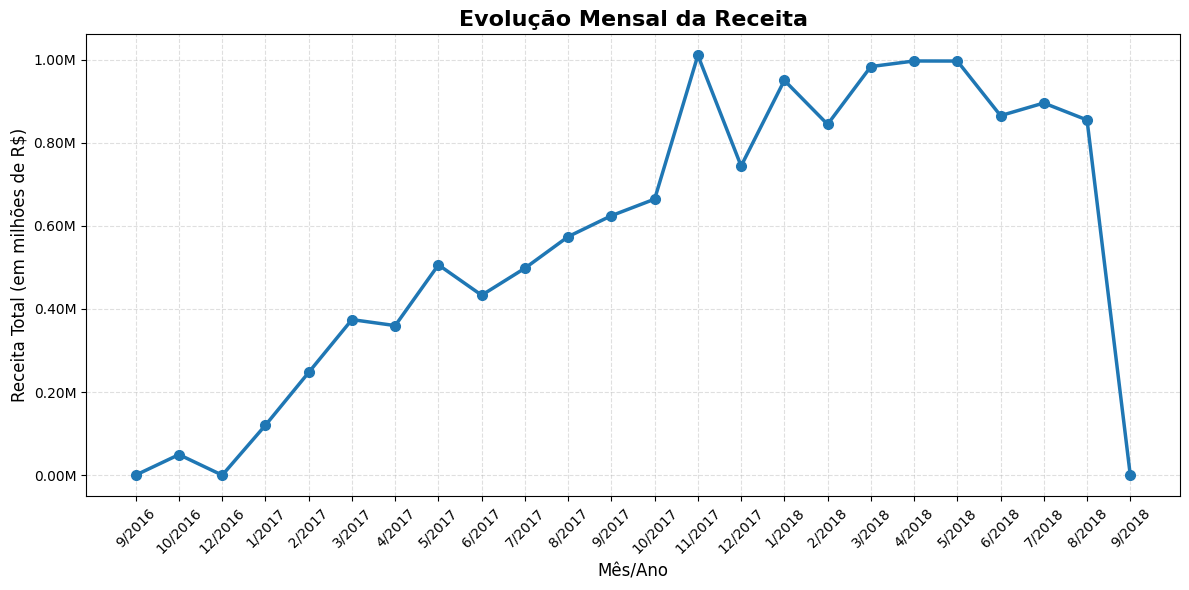

In [44]:
df_tempo['mes_ano'] = df_tempo['month'].astype(str) + '/' + df_tempo['year'].astype(str)

plt.figure(figsize=(12,6))

plt.plot(df_tempo['mes_ano'], df_tempo['receita'],
         linewidth=2.5, marker='o', markersize=7)

plt.title("Evolução Mensal da Receita", fontsize=16, fontweight='bold')
plt.xlabel("Mês/Ano", fontsize=12)
plt.ylabel("Receita Total (em milhões de R$)", fontsize=12)

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)

# --- Formatar eixo Y em milhões ---
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:.2f}M')
)

plt.tight_layout()
plt.savefig("grafico_1_evolucao.png", dpi=250)
plt.show()

A série temporal revela o comportamento das vendas ao longo dos meses, permitindo identificar tendências, sazonalidade e picos como o aumento típico na Black Friday. É útil para planejamento de estoque e marketing.

##2) Gráfico de Barras — Top 10 Categorias por Receita

In [ ]:
df_top = conn.execute("""
SELECT
    p.product_category_english AS categoria,
    SUM(f.price) AS receita
FROM fact_sales f
JOIN dim_product p ON f.product_key = p.product_key
GROUP BY categoria
ORDER BY receita DESC
LIMIT 10;
""").fetchdf()


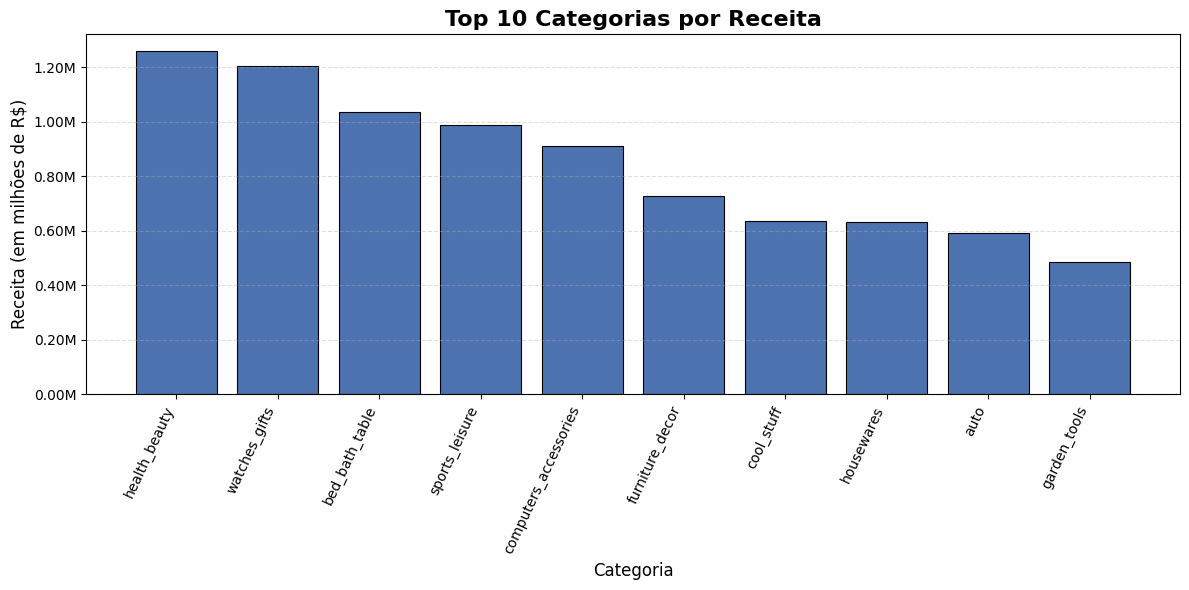

In [45]:
plt.figure(figsize=(12,6))

plt.bar(df_top['categoria'],
        df_top['receita'],
        color="#4C72B0", edgecolor="black", linewidth=0.8)

plt.title("Top 10 Categorias por Receita", fontsize=16, fontweight='bold')
plt.xlabel("Categoria", fontsize=12)
plt.ylabel("Receita (em milhões de R$)", fontsize=12)

plt.xticks(rotation=65, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# --- Formatação do eixo Y em milhões ---
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:.2f}M')
)

plt.tight_layout()
plt.savefig("grafico_2_top_produtos.png", dpi=250)
plt.show()

O gráfico mostra quais categorias geram mais receita, permitindo entender onde o negócio tem maior força e quais segmentos poderiam receber mais investimento em marketing ou estoque.

## 3) Heatmap — Receita por Estado vs Mês

In [ ]:
df_heat = conn.execute("""
SELECT
    c.customer_state AS estado,
    d.month AS mes,
    SUM(f.price) AS receita
FROM fact_sales f
JOIN dim_customer c ON f.customer_key = c.customer_key
JOIN dim_date d ON f.date_key = d.date_key
GROUP BY estado, mes
ORDER BY estado, mes;
""").fetchdf()


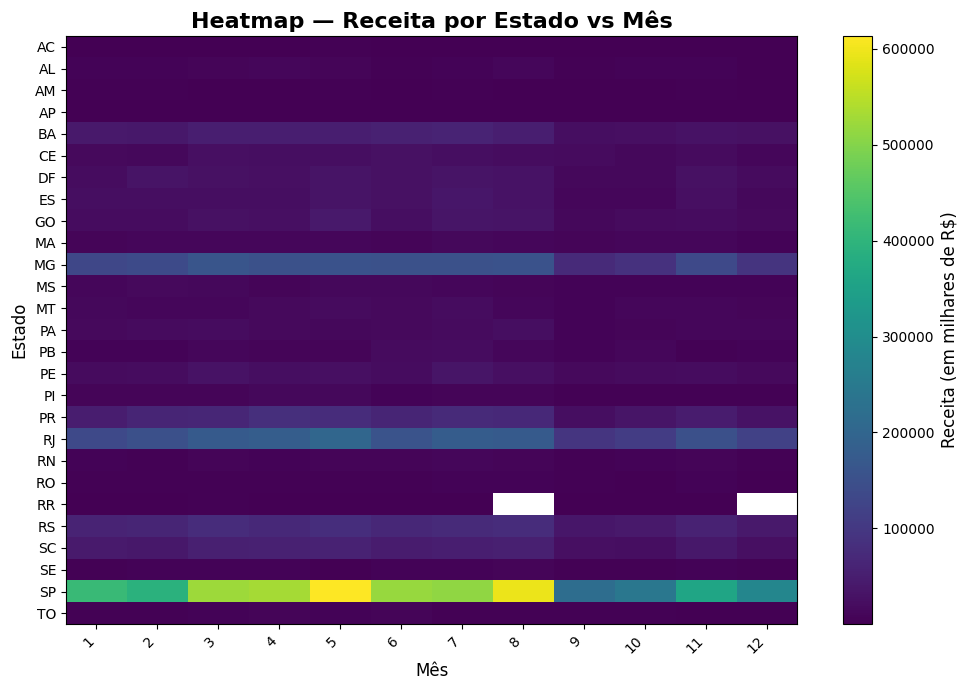

In [46]:
heat = df_heat.pivot(index='estado', columns='mes', values='receita')

plt.figure(figsize=(10,7))

# Escolha de colormap mais elegante
plt.imshow(heat, aspect='auto', cmap='viridis')

# Barra de cores
cbar = plt.colorbar()
cbar.set_label("Receita (em milhares de R$)", fontsize=12)

plt.title("Heatmap — Receita por Estado vs Mês", fontsize=16, fontweight="bold")
plt.xlabel("Mês", fontsize=12)
plt.ylabel("Estado", fontsize=12)

# Ticks
plt.xticks(
    ticks=np.arange(len(heat.columns)),
    labels=heat.columns,
    rotation=45,
    ha='right'
)
plt.yticks(np.arange(len(heat.index)), heat.index)

# Adicionar grid leve (opcional, mas deixa mais organizado)
plt.grid(visible=False)

plt.tight_layout()
plt.savefig("grafico_3_heatmap.png", dpi=250)
plt.show()

O heatmap evidencia em quais estados e meses a demanda é mais forte, revelando regiões estratégicas e períodos de alto consumo — excelente para logística, mídia geográfica e promoções sazonais.

## Dashboard

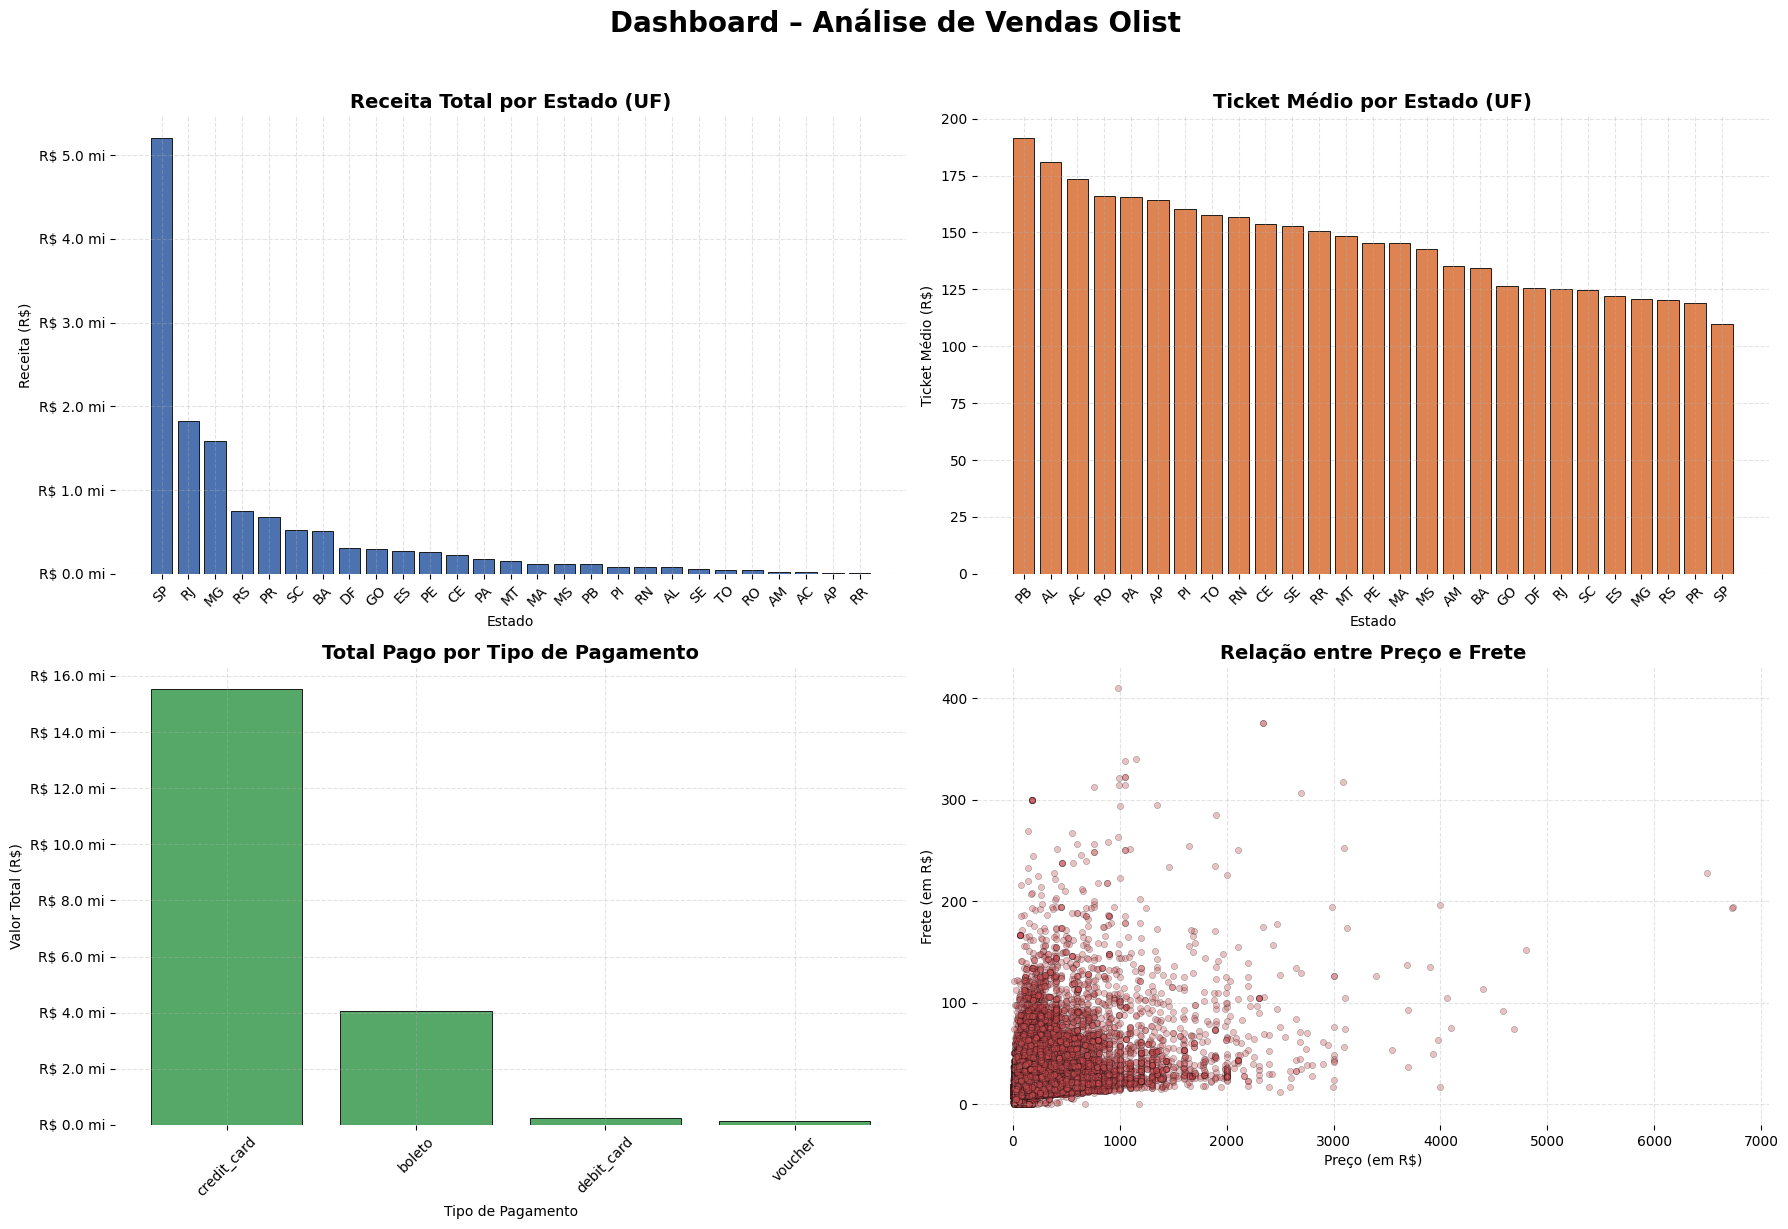

In [50]:
# ------------------------------
# Conexão
# ------------------------------
conn = duckdb.connect('/content/olist_dw.duckdb')

# ------------------------------
# Paleta de cores
# ------------------------------
color_line = "#4C72B0"     # azul
color_bar1 = "#DD8452"     # laranja queimado
color_bar2 = "#55A868"     # verde elegante
color_scatter = "#C44E52"  # vermelho escuro

# ------------------------------
# Consultas
# ------------------------------
df_estado = conn.execute("""
SELECT c.customer_state AS estado, SUM(f.price) AS receita
FROM fact_sales f
JOIN dim_customer c ON f.customer_key = c.customer_key
GROUP BY estado
ORDER BY receita DESC;
""").fetchdf()

df_ticket = conn.execute("""
SELECT c.customer_state AS estado, AVG(f.price) AS ticket_medio
FROM fact_sales f
JOIN dim_customer c ON f.customer_key = c.customer_key
GROUP BY estado
ORDER BY ticket_medio DESC;
""").fetchdf()

df_pay = conn.execute("""
SELECT COALESCE(pt.payment_type, 'Unknown') AS payment_type,
       SUM(f.payment_value) AS total_pago
FROM fact_sales f
LEFT JOIN dim_payment_type pt
    ON f.payment_type_key = pt.payment_type_key
GROUP BY payment_type
ORDER BY total_pago DESC;
""").fetchdf()

df_scatter = conn.execute("""
SELECT price, freight_value
FROM fact_sales
WHERE price > 0 AND freight_value > 0;
""").fetchdf()


# ------------------------------
# Formatação em milhões
# ------------------------------
def milhoes(x, pos):
    return f'R$ {x/1_000_000:.1f} mi'


# ------------------------------
# Dashboard
# ------------------------------
plt.style.use("default")

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Dashboard – Análise de Vendas Olist", fontsize=20, fontweight="bold", y=1.02)

# Função utilitária p/ adicionar grid e remover bordas
def format_axes(ax):
    ax.grid(True, linestyle="--", alpha=0.35)
    for spine in ax.spines.values():
        spine.set_visible(False)


# ---- 1) Receita por estado ----
axs[0,0].bar(df_estado["estado"], df_estado["receita"],
             color=color_line, edgecolor="black", linewidth=0.6)
axs[0,0].set_title("Receita Total por Estado (UF)", fontsize=14, fontweight="bold")
axs[0,0].set_xlabel("Estado")
axs[0,0].set_ylabel("Receita (R$)")
axs[0,0].tick_params(axis="x", rotation=45)
axs[0,0].yaxis.set_major_formatter(FuncFormatter(milhoes))
format_axes(axs[0,0])


# ---- 2) Ticket médio por estado ----
axs[0,1].bar(df_ticket["estado"], df_ticket["ticket_medio"],
             color=color_bar1, edgecolor="black", linewidth=0.6)
axs[0,1].set_title("Ticket Médio por Estado (UF)", fontsize=14, fontweight="bold")
axs[0,1].set_xlabel("Estado")
axs[0,1].set_ylabel("Ticket Médio (R$)")
axs[0,1].tick_params(axis="x", rotation=45)
format_axes(axs[0,1])


# ---- 3) Total pago por tipo de pagamento ----
axs[1,0].bar(df_pay["payment_type"], df_pay["total_pago"],
             color=color_bar2, edgecolor="black", linewidth=0.6)
axs[1,0].set_title("Total Pago por Tipo de Pagamento", fontsize=14, fontweight="bold")
axs[1,0].set_xlabel("Tipo de Pagamento")
axs[1,0].set_ylabel("Valor Total (R$)")
axs[1,0].tick_params(axis="x", rotation=45)
axs[1,0].yaxis.set_major_formatter(FuncFormatter(milhoes))
format_axes(axs[1,0])


# ---- 4) Scatter Preço x Frete ----
axs[1,1].scatter(df_scatter["price"], df_scatter["freight_value"],
                 color=color_scatter, alpha=0.35, s=20, edgecolor="black", linewidth=0.4)
axs[1,1].set_title("Relação entre Preço e Frete", fontsize=14, fontweight="bold")
axs[1,1].set_xlabel("Preço (em R$)")
axs[1,1].set_ylabel("Frete (em R$)")
format_axes(axs[1,1])


plt.tight_layout()
plt.savefig("dashboard_olist.png", dpi=300, bbox_inches="tight")
plt.show()

# Exemplo de otimização

Após a construção completa do Data Warehouse e das análises descritivas, realizamos uma etapa dedicada à otimização de desempenho das consultas analíticas.
O objetivo aqui é simular o comportamento de um ambiente real de BI, onde grandes volumes de dados exigem estratégias de aceleração para garantir respostas rápidas a dashboards e relatórios executivos.

Nesta fase, aplicamos essa pipeline:

🔹 1) Criação de uma Tabela Agregada (Aggregate Table)

Construímos a tabela agg_monthly_sales, que armazena métricas já agregadas por ano × mês.
Isso elimina a necessidade de recalcular somas e contagens sobre milhões de registros da fato, reduzindo drasticamente o custo computacional.

🔹 2) Comparação entre a Query Original e a Query Otimizada

Executamos a consulta mensal:

diretamente sobre a tabela fato (fact_sales)

e sobre a tabela agregada (agg_monthly_sales)

Ambas as versões são armazenadas em tabelas auxiliares (results_original e results_optimized), permitindo comparar resultados e garantir consistência.

🔹 3) EXPLAIN ANALYZE

Aplicamos EXPLAIN ANALYZE em ambas as versões da consulta para medir:

tempo total de execução

número de linhas processadas

operadores do plano de execução usados pelo DuckDB

Esse diagnóstico evidencia o ganho de performance obtido ao substituir a consulta detalhada pela leitura direta da tabela agregada.

## Criar arquivo .sql de otimização

In [ ]:
%%writefile 05_performance.sql
--------------------------------------------------------------------
-- ETAPA 5 — Performance e Otimização (Olist DW)
-- Gera tabela agregada, realiza consultas e produz EXPLAIN ANALYZE
--------------------------------------------------------------------

-- 1) Remover tabela agregada anterior (se existir)

DROP TABLE IF EXISTS agg_monthly_sales;

CREATE TABLE agg_monthly_sales AS
SELECT
d.year,
d.month,
SUM(f.price) AS receita,
COUNT(*) AS qtd_itens
FROM fact_sales f
JOIN dim_date d ON f.date_key = d.date_key
GROUP BY 1,2
ORDER BY 1,2;

-- 3) Consultar resultados originais e otimizados (sem EXPLAIN)

-- Resultados originais
CREATE OR REPLACE TABLE results_original AS
SELECT
d.year,
d.month,
SUM(f.price) AS receita,
COUNT(*) AS qtd_itens
FROM fact_sales f
JOIN dim_date d ON f.date_key = d.date_key
GROUP BY 1,2
ORDER BY 1,2;

-- Resultados otimizados usando tabela agregada
CREATE OR REPLACE TABLE results_optimized AS
SELECT *
FROM agg_monthly_sales
ORDER BY year, month;

-- 4) EXPLAIN ANALYZE para verificar performance

EXPLAIN ANALYZE
SELECT
d.year,
d.month,
SUM(f.price) AS receita,
COUNT(*) AS qtd_itens
FROM fact_sales f
JOIN dim_date d ON f.date_key = d.date_key
GROUP BY 1,2
ORDER BY 1,2;

EXPLAIN ANALYZE
SELECT *
FROM agg_monthly_sales
ORDER BY year, month;

COPY agg_monthly_sales
TO 'agg_monthly_sales.parquet'
(FORMAT PARQUET);

Writing 05_performance.sql


## Rodar a otimização

In [ ]:
# roda o SQL de performance
with open("05_performance.sql", "r") as f:
    conn.execute(f.read())

print("Arquivo 05_performance.sql executado com sucesso!")

Arquivo 05_performance.sql executado com sucesso!


In [ ]:
# Rodar EXPLAIN ANALYZE e mostrar de forma legível
def show_explain(sql, conn):
    result = conn.execute(f"EXPLAIN ANALYZE {sql}").fetchall()
    for row in result:
        print(row[1])  # a coluna 'analyzed_plan' é a segunda na tupla

print("=== EXPLAIN ORIGINAL ===")
show_explain("""
SELECT
    d.year,
    d.month,
    SUM(f.price) AS receita,
    COUNT(*) AS qtd_itens
FROM fact_sales f
JOIN dim_date d ON f.date_key = d.date_key
GROUP BY 1,2
ORDER BY 1,2;
""", conn)

print("\n=== EXPLAIN OTIMIZADA ===")
show_explain("""
SELECT *
FROM agg_monthly_sales
ORDER BY year, month;
""", conn)



=== EXPLAIN ORIGINAL ===
┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
EXPLAIN ANALYZE  SELECT     d.year,     d.month,     SUM(f.price) AS receita,     COUNT(*) AS qtd_itens FROM fact_sales f JOIN dim_date d ON f.date_key = d.date_key GROUP BY 1,2 ORDER BY 1,2; 
┌────────────────────────────────────────────────┐
│┌──────────────────────────────────────────────┐│
││              Total Time: 0.0119s             ││
│└──────────────────────────────────────────────┘│
└────────────────────────────────────────────────┘
┌───────────────────────────┐
│           QUERY           │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│      EXPLAIN_ANALYZE      │
│    ────────────────────   │
│           0 Rows          │
│          (0.00s)          │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│         PROJECTION       

## Resultados

A query original retornou o plano, com tempo total de aproximadamente 0.0119s. Apesar de rápido (dataset pequeno), o plano revela:

- Hash Join entre fato e dimensão

- 112.650 linhas lidas da fact_sales

- Agrupamento (PERFECT_HASH_GROUP_BY) realizado em tempo de execução

- Necessidade de projeções e decompress/compress internas

- Ordenação final executada sobre dados agrupados

Esse caminho completo exige leituras, join, agregação e ordenação, tornando a consulta mais custosa conforme o volume cresce.

Já a versão otimizada, usando agg_monthly_sales, obteve tempo total de apenas 0.0014s, apresentando:

- Leitura direta de somente 24 linhas (já agregadas)

- Nenhum join

- Nenhuma etapa de agrupamento

- Somente projeção + ordenação final

- Quase todo o custo do cálculo removido

### Considerações

A criação da tabela agregada mensal reduz drasticamente o trabalho necessário para responder consultas analíticas. No cenário analisado:

A consulta otimizada foi cerca de 8,5 vezes mais rápida
(0.0119s → 0.0014s)

Mesmo em um dataset pequeno, a diferença já aparece. Em bases reais com milhões de linhas, essa abordagem tende a:

- Diminuir a carga computacional,

- Acelerar dashboards,

- Reduzir custos de infraestrutura,

- Minimizar contenção em ambientes OLTP.